# Bitcoin Elliptic

Experiment on the [Bitcoin Elliptic](https://www.kaggle.com/datasets/ellipticco/elliptic-data-set) data set. Temporal graph where every timestep is a block of transactions. We want to classify fraudulent nodes (class 1). There are also a bunch of unlabeled nodes (class -1).

In [1]:
# required to import local package

import os
import sys
module_path = os.path.abspath(os.path.join('../../'))
if module_path not in sys.path:
    sys.path.append(module_path)

# Read dataset

In [2]:
import pandas as pd
import torch
from torch_geometric.data import Data

# target to torch tensor
target_df = pd.read_csv("dataset/elliptic_bitcoin_dataset/elliptic_txs_classes.csv")

# make class binary
target_df["class"] = target_df["class"].replace("unknown", "-1")
target_df["class"] = target_df["class"].replace("2", "0")
target_df["class"] = pd.to_numeric(target_df["class"])
target = torch.tensor(target_df["class"].values)

# node features to torch tensor
x_df = pd.read_csv("dataset/elliptic_bitcoin_dataset/elliptic_txs_features.csv", header=None)
id_df = x_df[0]
x_df = x_df.drop(columns=0) # drop id column
x_tensor = torch.tensor(x_df.values).float()

# replace ids
id_df = pd.to_numeric(id_df)
id_df = id_df.reset_index()
id_df = id_df.rename(columns={"index":"New_ID"})
id_df = id_df.rename(columns={0:"Old_ID"})
id_dict = dict(zip(id_df["Old_ID"].values,id_df["New_ID"].values))

# edges to torch tensor
edges_df = pd.read_csv("dataset/elliptic_bitcoin_dataset/elliptic_txs_edgelist.csv")
edges_df["txId1"] = pd.to_numeric(edges_df["txId1"])
edges_df["txId2"] = pd.to_numeric(edges_df["txId2"])

# replace ids
edges_df["txId1"] = edges_df["txId1"].apply(lambda x: id_dict[x])
edges_df["txId2"] = edges_df["txId2"].apply(lambda x: id_dict[x])

edge_index = torch.LongTensor((edges_df["txId1"].values,edges_df["txId2"].values))

# put together graph
data = Data(x=x_tensor, edge_index=edge_index, y=target)

data.num_classes = 2

print(data)

Data(x=[203769, 166], edge_index=[2, 234355], y=[203769], num_classes=2)


## Inspect data

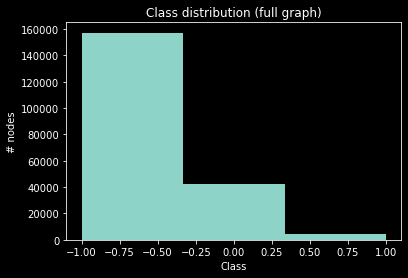

In [3]:
import matplotlib.pyplot as plt

plt.title("Class distribution (full graph)")
plt.hist(data.y.reshape(-1).detach().numpy(), 3)
plt.xlabel("Class")
plt.ylabel("# nodes")
plt.show()

graph is strongly connected component: False
graph is weakly connected component: False
graph has # weakly connected components: 49
graph has # isolated nodes: 0


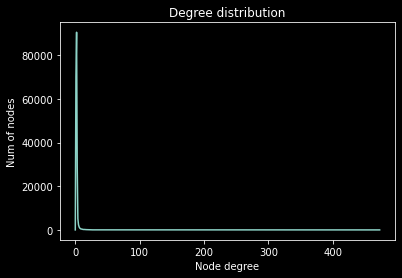

In [4]:
from lib import util

util.describe_graph(data)

## Split data set

In [5]:
from lib.data import split_dataset

train_data, calibration_indices, test_indices = split_dataset(data, 0.2, 0.2)

print("Train set: {}".format(train_data))
print("Calibration set size: {}".format(len(calibration_indices)))
print("Test set size: {}".format(len(test_indices)))

Train set: Data(x=[130413, 166], edge_index=[2, 96833], y=[130413])
Calibration set size: 32603
Test set size: 40753


## Inspect Train set

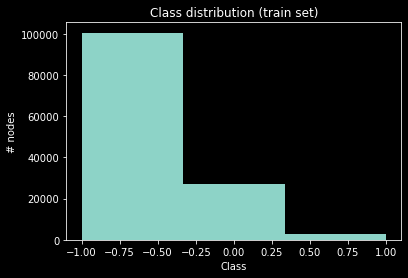

In [6]:
plt.title("Class distribution (train set)")
plt.hist(train_data.y.reshape(-1).detach().numpy(), 3)
plt.xlabel("Class")
plt.ylabel("# nodes")
plt.show()

graph is strongly connected component: False
graph is weakly connected component: False
graph has # weakly connected components: 39855
graph has # isolated nodes: 24270


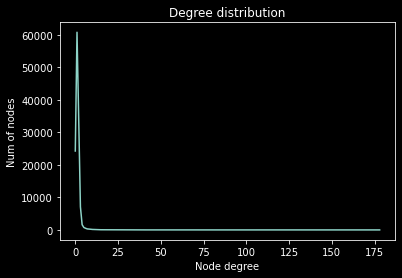

In [7]:
util.describe_graph(train_data)

## Inspect calibration data

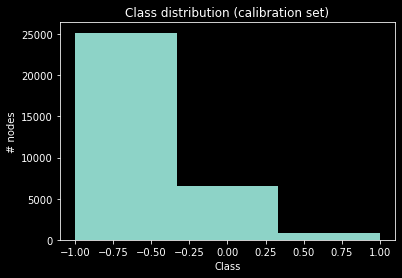

In [8]:
plt.title("Class distribution (calibration set)")
plt.hist(data.y[calibration_indices].reshape(-1).detach().numpy(), 3)
plt.xlabel("Class")
plt.ylabel("# nodes")
plt.show()

## Inspect test data

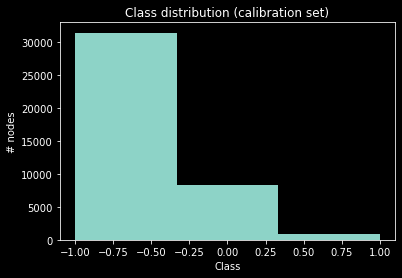

In [9]:
plt.title("Class distribution (calibration set)")
plt.hist(data.y[test_indices].reshape(-1).detach().numpy(), 3)
plt.xlabel("Class")
plt.ylabel("# nodes")
plt.show()

# GraphSAGE model

In [10]:
from lib.graphsage import GraphSAGE
import copy
from lib.evaluation import get_binary_classification_performance

args = {
    "num_layers": 2,
    "hidden_dim": 512,
    "lr": 0.01, # learning rate
    "epochs": 15,
    "batch_size": 128,
    "num_neighbors": [25, 10],
    "max_stagnation": 5,
}

model = GraphSAGE(data.num_features, args["hidden_dim"], data.num_classes, args["num_layers"], args["num_neighbors"])


# reset the parameters to initial random value
model.reset_parameters()

optimizer = torch.optim.Adam(model.parameters(), lr=args["lr"])

nll_loss = torch.nn.NLLLoss(weight=torch.tensor([0.2,1])) # negative log-likelihood
def custom_loss_fn(y_hat, y_true):
  known_class_indices = y_true != -1
  return nll_loss(y_hat[known_class_indices], y_true[known_class_indices])

loss_fn = custom_loss_fn

best_model = None
best_f1 = 0
stagnation_counter = 0

for epoch in range(1, 1 + args["epochs"]):
    loss = model.train_model(train_data, optimizer, loss_fn, args["batch_size"])
    
    # evaluate
    y_hat = model.predict(data)
    y_hat = y_hat[test_indices]
    y_hat = y_hat.argmax(dim=-1, keepdim=True).reshape(-1)
    
    y_true = data.y[test_indices].reshape(-1)
    
    known_class_mask = y_true != -1
    test_acc, test_f1_class_0, test_f1_class_1 = get_binary_classification_performance(y_hat[known_class_mask], y_true[known_class_mask])
    
    if test_f1_class_1 > best_f1:
        best_f1 = test_f1_class_1
        best_model = copy.deepcopy(model)
        stagnation_counter = 0
    else:
        stagnation_counter += 1

    print(f"Epoch: {epoch:02d}, "
            f"Loss: {loss:.4f}, "
            f"Test acc: {100 * test_acc:.2f}%, "
            f"Test f1 (class 0): {100 * test_f1_class_0:.2f}%, "
            f"Test f1 (class 1): {100 * test_f1_class_1:.2f}%, "
            f"Stagnation: {stagnation_counter}")
    
    if stagnation_counter >= args["max_stagnation"]:
        print("Training stopped due to stagnation. Best acc: {}".format(best_f1))
        break

/usr/local/anaconda3/envs/pytorch/lib/python3.7/site-packages/ipykernel_launcher.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 01, Loss: -0.4828, Test acc: 89.65%, Test f1 (class 0): 94.54%, Test f1 (class 1): 1.84%, Stagnation: 0


/usr/local/anaconda3/envs/pytorch/lib/python3.7/site-packages/ipykernel_launcher.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 02, Loss: -0.4828, Test acc: 70.94%, Test f1 (class 0): 82.58%, Test f1 (class 1): 12.37%, Stagnation: 0
